In [90]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import trompy as tp

import dill

from utils import make_realigned_trials, get_time_moving, scale_vlim_to_data, otsu_threshold

rcParams['font.family'] = 'Arial'
plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['savefig.transparent'] = True
colors = ["#67AFD2", "#016895", "#F4795B", "#C74632"]
custom_cmap = LinearSegmentedColormap.from_list("custom_diverging", [colors[1], "white", colors[3]])

DATAFOLDER = Path("..//data")
RESULTSFOLDER = Path("..//results")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [91]:
## Loading data...

# with open(DATAFOLDER / "behav_data.pickle", "rb") as f:
#     data = dill.load(f)

# x_array = data["x_vel"]
# #snips_photo = data["snips_photo"]
# snips_vel = data["snips_vel"]
# snips_still = data["snips_still"]

with open(DATAFOLDER / "movement_data.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_movement"]
snips_movement = data["snips_movement"]

# with open(DATAFOLDER / "movement_data_z.pickle", "rb") as f:
#     data = dill.load(f)

# x_array = data["x_array"]
# snips_movement_z = data["snips_movement_z"]

# with open(DATAFOLDER / "angvel_data_z.pickle", "rb") as f:
#     data = dill.load(f)

# x_array = data["x_array"]
# snips_angvel_z = data["snips_ang_vel_z"]

with open(DATAFOLDER / "sigmoidal_fits.pickle", "rb") as f:
    fits = dill.load(f)

fits_df_cluster_raw = fits["fits_df_cluster_raw"]
fits_df_clusterness = fits["fits_df_clusterness"]
fits_df_euclidean = fits["fits_df_euclidean"]

In [92]:
# Add time moving to x array
# thr = otsu_threshold(snips_movement.flatten())
thr = 0.02
x_array = x_array.assign(time_moving=get_time_moving(snips_movement, threshold=thr))
print(thr)

0.02


In [93]:
# Make realigned index

df_red = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'")
df_red = make_realigned_trials(df_red, fits_df_cluster_raw, verbose=False)

In [94]:
df_red.columns

Index(['trial', 'id', 'condition', 'infusiontype', 'time_moving',
       'trial_aligned'],
      dtype='object')

<Axes: xlabel='trial_aligned'>

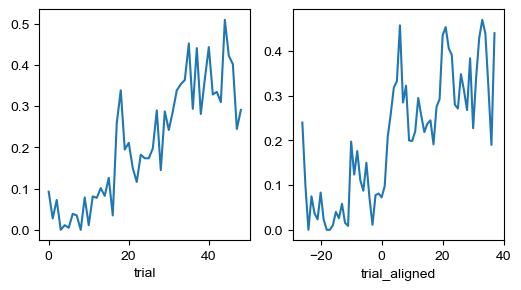

In [73]:

f, ax = plt.subplots(ncols=2, figsize=(6, 3))
df_red.groupby("trial").time_moving.mean().plot(ax=ax[0])
df_red.groupby("trial_aligned").time_moving.mean().plot(ax=ax[1])


trial fit params (a,b,c,d): [3.81992117e-01 1.35994963e-01 2.25199496e+01 8.59772713e-03]
trial_aligned fit params (a,b,c,d): [ 0.24625648  1.76033805 27.98181924  0.06993338]


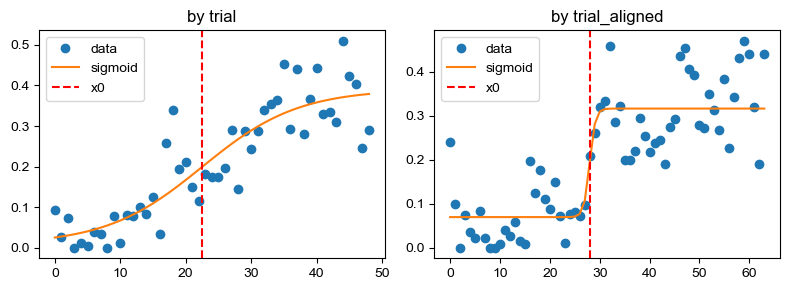

In [74]:
# Fit sigmoid to grouped time_moving series (by trial and by trial_aligned)
import numpy as np
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c, d):
    return d + a / (1.0 + np.exp(-b*(x-c)))

# get the series
y_trial = df_red.groupby('trial').time_moving.mean().values
x_trial = np.arange(len(y_trial))
y_al = df_red.groupby('trial_aligned').time_moving.mean().values
x_al = np.arange(len(y_al))

# fit for 'trial'
p0 = [(y_trial.max() - y_trial.min()), 1.0, np.median(x_trial), y_trial.min()]
try:
    popt_trial, pcov_trial = curve_fit(sigmoid, x_trial, y_trial, p0=p0, maxfev=10000)
    print('trial fit params (a,b,c,d):', popt_trial)
except Exception as e:
    popt_trial = None
    print('trial fit failed:', e)

# fit for 'trial_aligned'
p0_al = [(y_al.max() - y_al.min()), 1.0, np.median(x_al), y_al.min()]
try:
    popt_al, pcov_al = curve_fit(sigmoid, x_al, y_al, p0=p0_al, maxfev=10000)
    print('trial_aligned fit params (a,b,c,d):', popt_al)
except Exception as e:
    popt_al = None
    print('trial_aligned fit failed:', e)

# plot fitted curves alongside data
f2, ax2 = plt.subplots(ncols=2, figsize=(8, 3))
ax2[0].plot(x_trial, y_trial, 'o', label='data')
if popt_trial is not None:
    ax2[0].plot(x_trial, sigmoid(x_trial, *popt_trial), '-', label='sigmoid')
    ax2[0].axvline(popt_trial[2], color='r', linestyle='--', label='x0')
ax2[0].set_title('by trial')
ax2[0].legend()
ax2[1].plot(x_al, y_al, 'o', label='data')
if popt_al is not None:
    ax2[1].plot(x_al, sigmoid(x_al, *popt_al), '-', label='sigmoid')
    ax2[1].axvline(popt_al[2], color='r', linestyle='--', label='x0')
ax2[1].set_title('by trial_aligned')
ax2[1].legend()
plt.tight_layout()

In [43]:

# f, ax = plt.subplots(figsize=(6, 2), ncols=3)
# sns.heatmap(snips_test,
#             vmin=scale_vlim_to_data(snips_test, percentile=pc)[0],
#             vmax=scale_vlim_to_data(snips_test, percentile=pc)[1],
#             ax=ax[0],
#             cmap=custom_cmap
#             )

# ax[1].plot(np.mean(snips_test[:,50:150], axis=1))
# ax[2].plot(get_time_moving(snips_test, threshold=0.018))

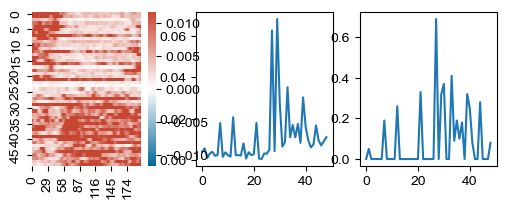

In [75]:
id = "PB26"

s = snips_movement[x_array.query("condition == 'deplete' & infusiontype == '45NaCl' & id == @id").index,:]

# s = tp.zscore(s, baseline_points=50)

f, ax = plt.subplots(figsize=(6, 2), ncols=3)
sns.heatmap(s,
            vmin=scale_vlim_to_data(s, percentile=pc)[0],
            vmax=scale_vlim_to_data(s, percentile=pc)[1],
            ax=ax[0],
            cmap=custom_cmap
            )

ax[1].plot(np.mean(s[:,50:150], axis=1))
ax[2].plot(get_time_moving(s, threshold=0.02))

PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)


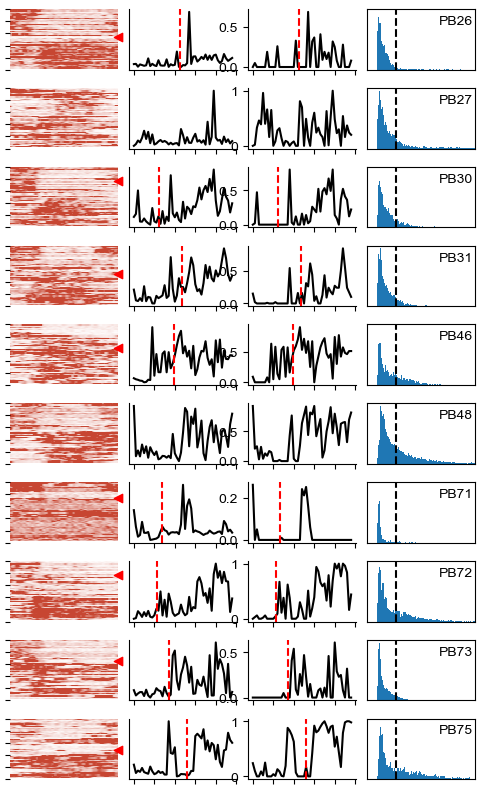

In [77]:

query_string = "condition == 'deplete' & infusiontype == '45NaCl'"

rats = x_array.query(query_string).id.unique()

pc = 80

f, ax = plt.subplots(nrows=len(rats), ncols=4, figsize=(6, len(rats)),
                     gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

for i, rat in enumerate(rats):
    query_string = f"condition == 'deplete' & infusiontype == '45NaCl' & id == '{rat}'"
    snips_tmp = snips_movement[x_array.query(query_string).index]
    print(rat, snips_tmp.shape)
    
    sns.heatmap(snips_tmp,
                vmin=scale_vlim_to_data(snips_tmp, percentile=pc)[0],
                vmax=scale_vlim_to_data(snips_tmp, percentile=pc)[1],
                ax=ax[i, 0],
                cmap=custom_cmap,
                cbar=False)
    
    ax[i, 0].set_yticks([0, 10, 20, 30, 40, 50], labels=["","","","","",""])
    ax[i, 0].set_xticks([])
    
    ax[i, 1].plot(np.nanmedian(snips_tmp[:,50:150], axis=1), color='k')
    ax[i, 1].set_xticks([0, 10, 20, 30, 40, 50], labels=["","","","","",""])
    ax[i, 1].set_yticks([])
    sns.despine(ax=ax[i, 1])
    
    # threshold from individual rats
    # thr = otsu_threshold(snips_tmp.flatten())
    # print(thr)

    # threshold from all rats
    # thr = otsu_threshold(snips_movement.flatten())
    thr=0.02

    ax[i, 2].plot(get_time_moving(snips_tmp, threshold=thr), color='k')
    ax[i, 2].set_xticks([0, 10, 20, 30, 40, 50], labels=["","","","","",""])
    sns.despine(ax=ax[i, 2])

    try:
        transition_point = fits_df_cluster_raw.query("id == @rat").x0_orig.values[0]
        ax[i, 0].scatter(200, transition_point, color='r', marker='<', clip_on=False)
        ax[i, 1].axvline(transition_point, color='r', linestyle='--')
        ax[i, 2].axvline(transition_point, color='r', linestyle='--')
    except:
        pass


    ax[i, 3].hist(snips_tmp.flatten(), bins=1000)
    ax[i, 3].set_xlim([-0.01, 0.1])
    ax[i, 3].set_xticks([])
    ax[i, 3].set_yticks([])
    ax[i, 3].axvline(thr, color='k', linestyle='--')
    
    ax[i, 3].text(0.98, 0.9, rat, transform=ax[i, 3].transAxes, ha='right', va='top')
    
# f.savefig(RESULTSFOLDER / "figure_snips_movement_deplete_45NaCl_individualrats.png", bbox_inches='tight')

In [97]:
x_array.columns

Index(['trial', 'id', 'condition', 'infusiontype', 'time_moving'], dtype='object')

In [98]:
snips_red = snips_movement[x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").index]
x_red = x_array.query("condition == 'deplete' & infusiontype == '45NaCl'").reset_index(drop=True)
x_red = make_realigned_trials(x_red, fits_df_cluster_raw, verbose=False)

snips_avg = []

for trial in x_red.trial_aligned.unique():
    snips_movement_tmp = snips_red[x_red.query("trial_aligned == @trial").index]
    snips_avg.append(np.nanmean(snips_movement_tmp, axis=0))

snips_avg = np.array(snips_avg)

<Axes: >

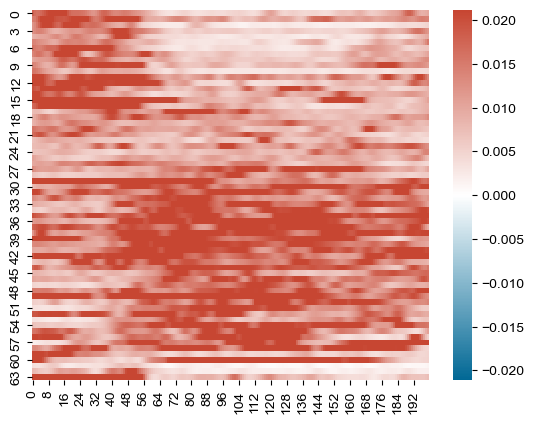

In [99]:
sns.heatmap(snips_avg,
            vmin=scale_vlim_to_data(snips_avg, percentile=pc)[0],
            vmax=scale_vlim_to_data(snips_avg, percentile=pc)[1],
            cmap=custom_cmap
            )

In [13]:
x_red = x.query("condition == 'deplete' & infusiontype == '45NaCl'")
x_red.shape

(490, 4)

In [3]:
def make_individual_rat_plots(x_array, snips_movement, fits_df_cluster_raw):
    query_string = "condition == 'deplete' & infusiontype == '45NaCl'"
    rats = x_array.query(query_string).id.unique()
    pc = 80
    f, ax = plt.subplots(nrows=len(rats), ncols=4, figsize=(6, len(rats)),
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.1})
    for i, rat in enumerate(rats):
        query_string = f"condition == 'deplete' & infusiontype == '45NaCl' & id == '{rat}'"
        snips_tmp = snips_movement[x_array.query(query_string).index]
        print(rat, snips_tmp.shape)
        
        sns.heatmap(snips_tmp,
                    vmin=scale_vlim_to_data(snips_tmp, percentile=pc)[0],
                    vmax=scale_vlim_to_data(snips_tmp, percentile=pc)[1],
                    ax=ax[i, 0],
                    cmap=custom_cmap,
                    cbar=False)
        
        ax[i, 0].set_yticks([0, 10, 20, 30, 40, 50], labels=["","","","","",""])
        ax[i, 0].set_xticks([])
        
        ax[i, 1].plot(np.nanmedian(snips_tmp[:,50:150], axis=1), color='k')
        ax[i, 1].set_xticks([0, 10, 20, 30, 40, 50], labels=["","","","","",""])
        
        # threshold from individual rats
        # thr = otsu_threshold(snips_tmp.flatten())
        # print(thr)

        # threshold from all rats
        # thr = otsu_threshold(snips_movement.flatten())
        thr=0.02

        ax[i, 2].plot(get_time_moving(snips_tmp, threshold=thr), color='k')
        ax[i, 2].set_xticks([0, 10, 20, 30, 40, 50], labels=["","","","","",""])

        try:
            transition_point = fits_df_cluster_raw.query("id == @rat").x0_orig.values[0]
            ax[i, 0].scatter(transition_point, -0.6, color='r', marker='x')
        except:
            pass

    return f, ax

In [5]:
# to plot for all bodyparts

with open(DATAFOLDER / "bodypart_data.pickle", "rb") as f:
    data = dill.load(f)

x_array = data["x_array"]
bodyparts = data["bodyparts"]

nose
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
r_ear
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
l_ear
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
head_base
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
back1
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
back2
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
back3
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 

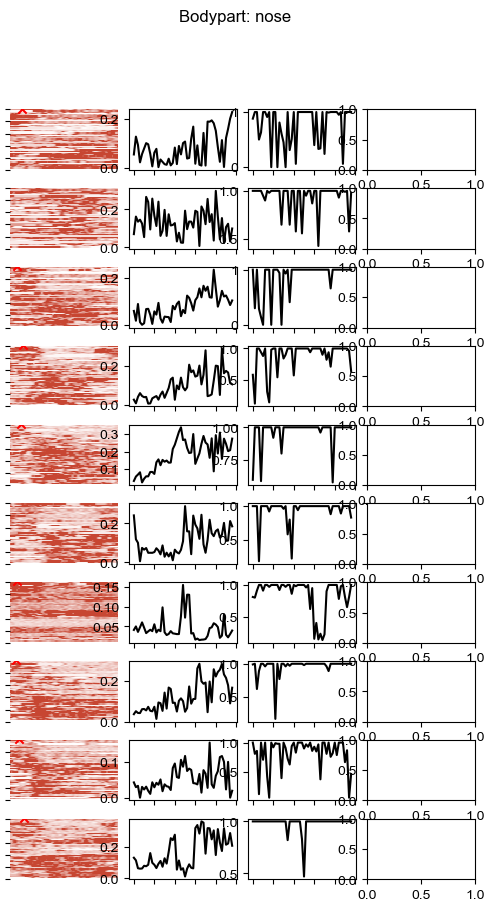

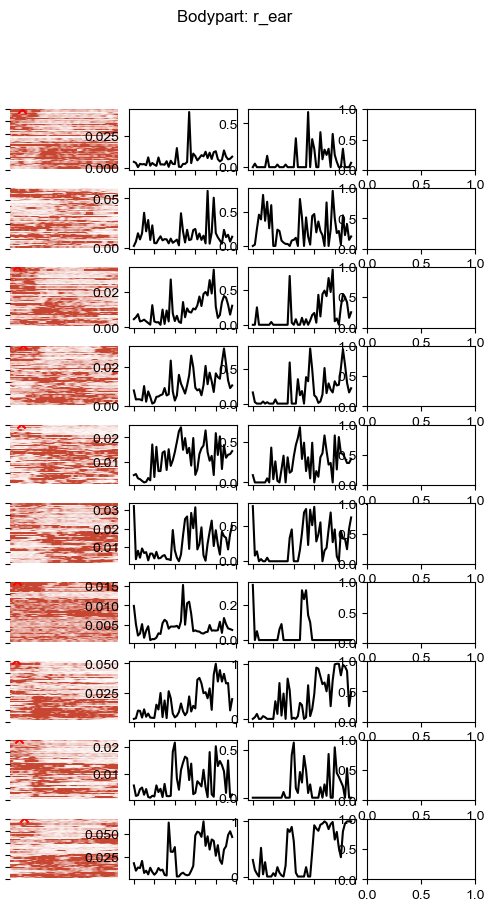

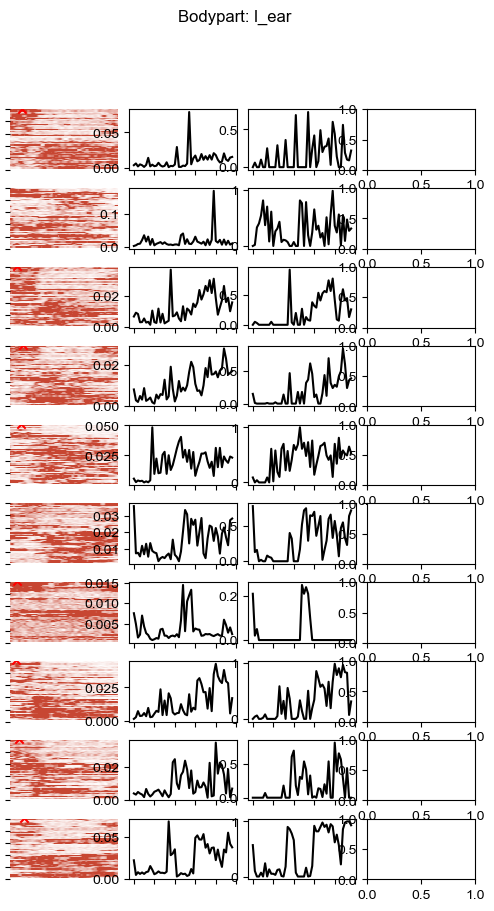

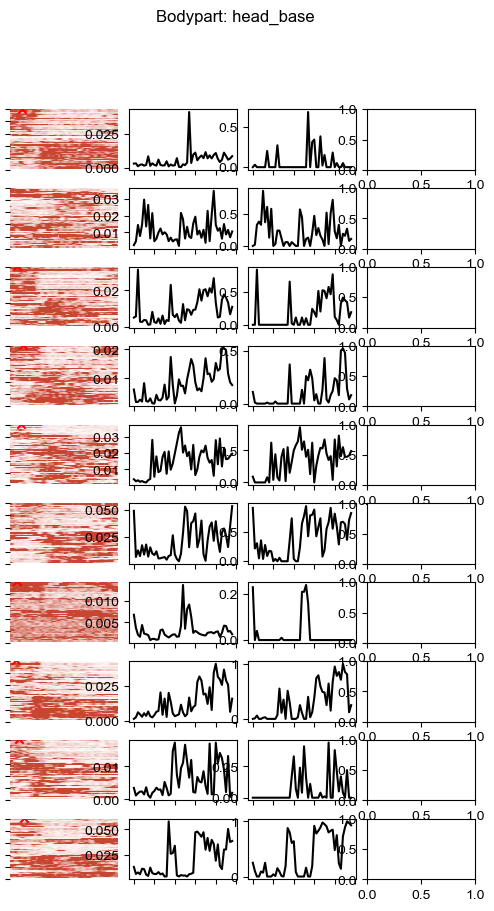

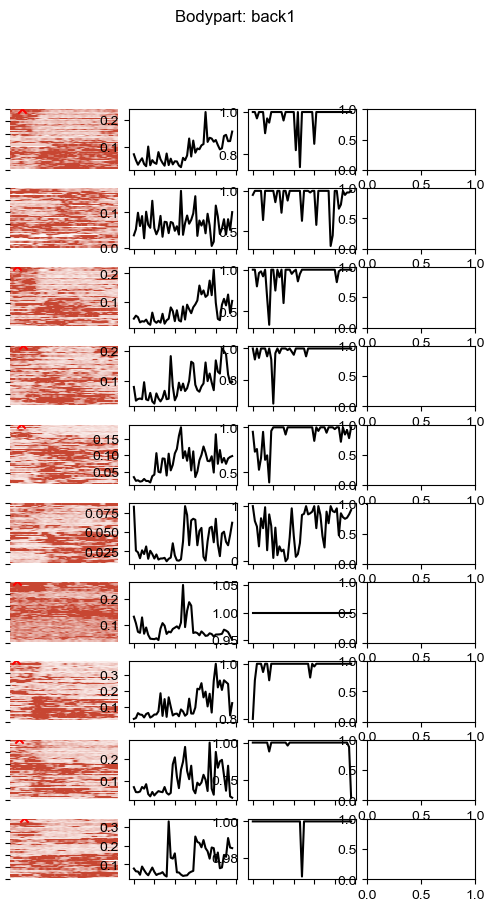

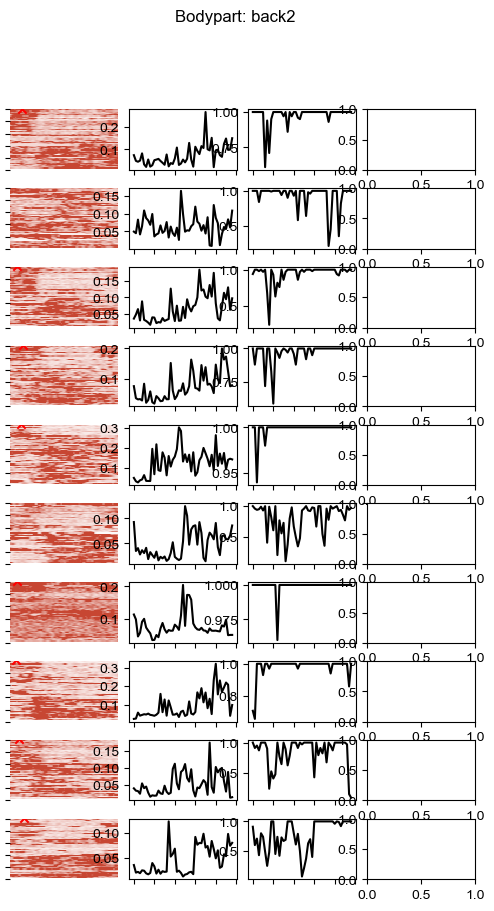

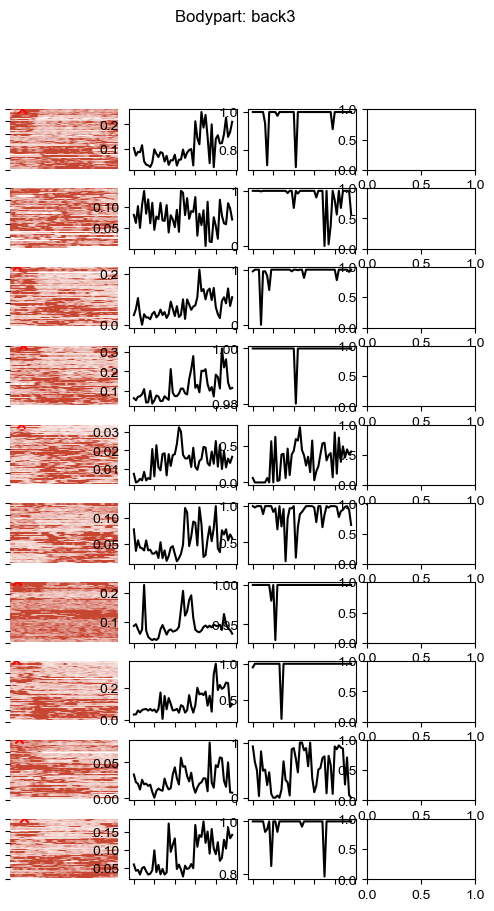

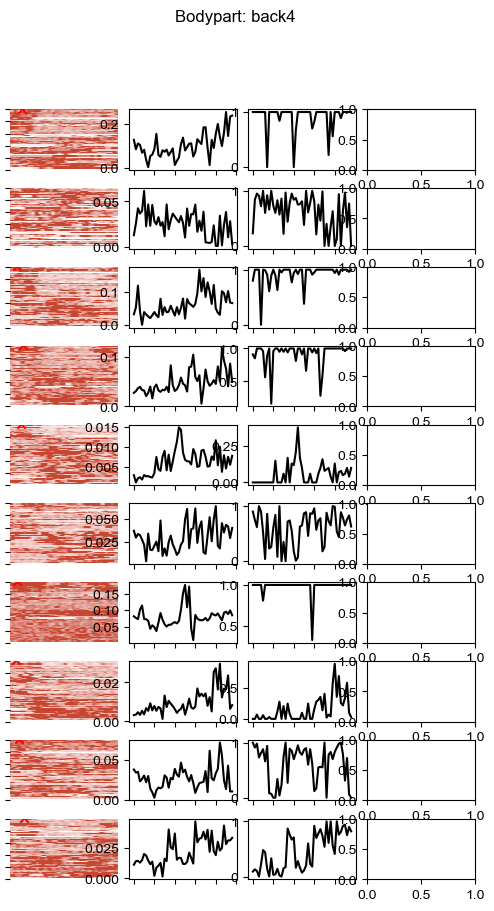

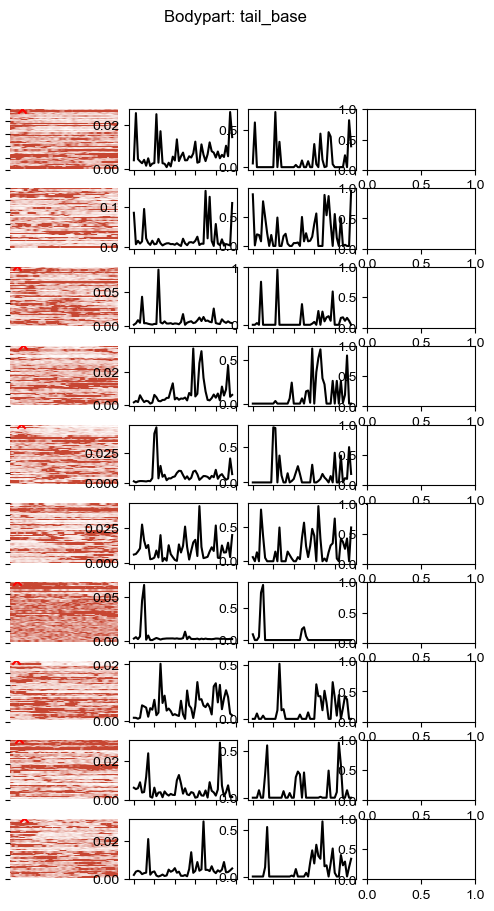

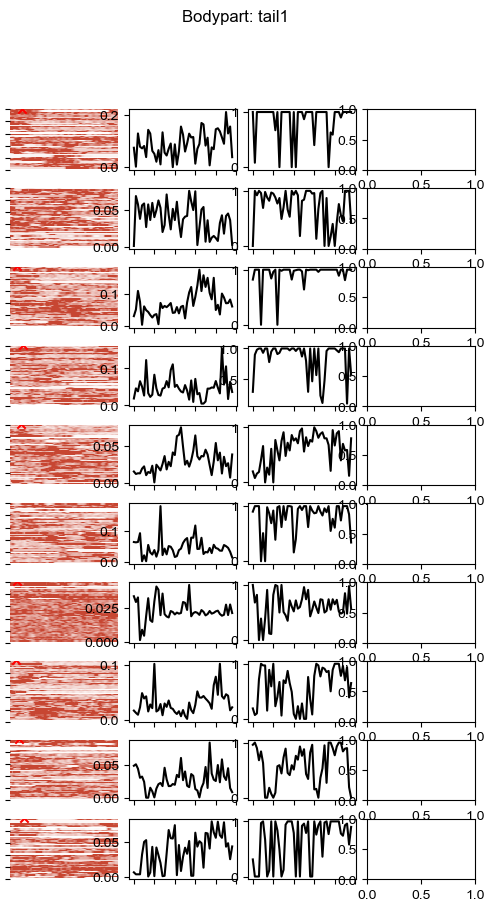

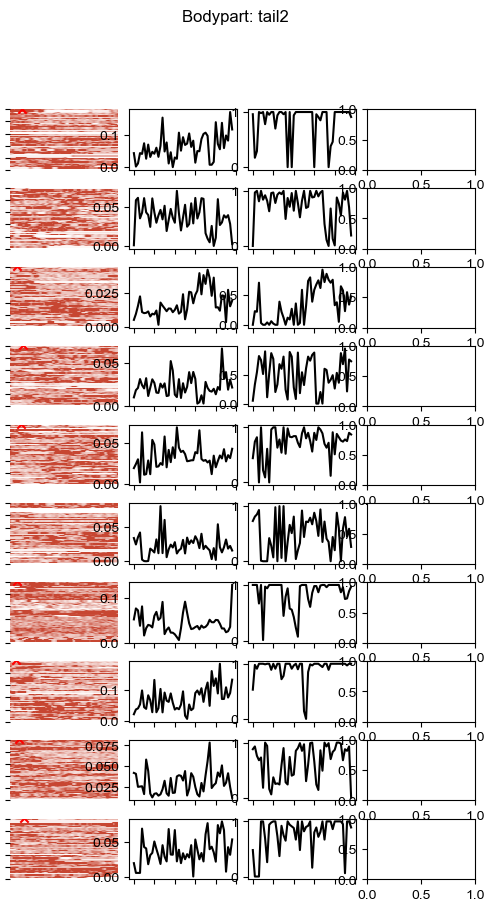

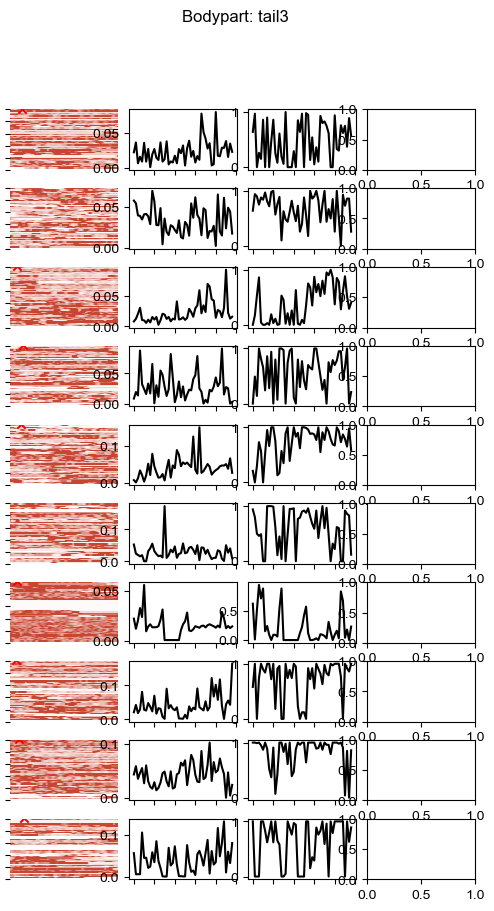

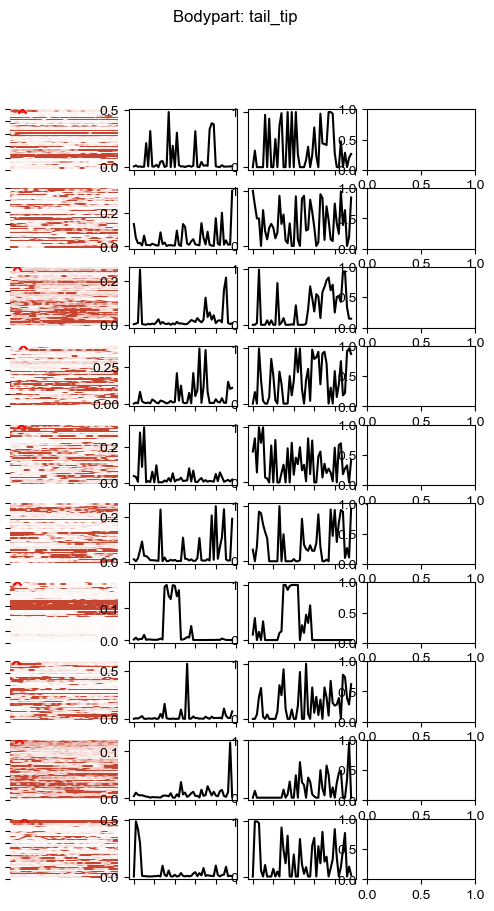

In [ ]:


for bodypart in bodyparts:
    print(bodypart)
    
    f, ax = make_individual_rat_plots(x_array, data[bodypart], fits_df_cluster_raw)
    f.suptitle(f"Bodypart: {bodypart}")
    f.savefig(RESULTSFOLDER / f"figure_snips_{bodypart}_deplete_45NaCl_individualrats.png", bbox_inches='tight')


PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 200)
PB72 (49, 200)
PB73 (49, 200)
PB75 (49, 200)
PB26 (49, 200)
PB27 (49, 200)
PB30 (49, 200)
PB31 (49, 200)
PB46 (49, 200)
PB48 (49, 200)
PB71 (49, 

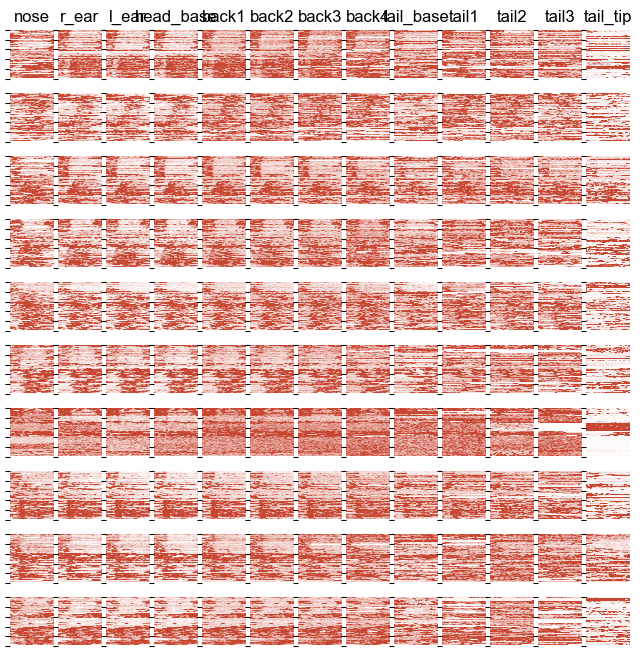

In [6]:
# make bodypart heatmaps

query_string = "condition == 'deplete' & infusiontype == '45NaCl'"
rats = x_array.query(query_string).id.unique()
pc = 80

f, ax = plt.subplots(ncols=len(bodyparts),
                     nrows=len(rats),
                     figsize=(8, 8),
                         gridspec_kw={'hspace': 0.3, 'wspace': 0.1})

for i, bodypart in enumerate(bodyparts):

    for j, rat in enumerate(rats):
        query_string = f"condition == 'deplete' & infusiontype == '45NaCl' & id == '{rat}'"
        snips_tmp = data[bodypart][x_array.query(query_string).index]
        print(rat, snips_tmp.shape)
        
        sns.heatmap(snips_tmp,
                    vmin=scale_vlim_to_data(snips_tmp, percentile=pc)[0],
                    vmax=scale_vlim_to_data(snips_tmp, percentile=pc)[1],
                    ax=ax[j, i],
                    cmap=custom_cmap,
                    cbar=False)
        
        ax[j, i].set_yticks([0, 10, 20, 30, 40, 50], labels=["","","","","",""])
        ax[j, i].set_xticks([])

    ax[0, i].set_title(bodypart)
     


In [7]:
f. savefig(RESULTSFOLDER / f"figure_snips_allbodyparts_deplete_45NaCl_individualrats.png", bbox_inches='tight')